In [1]:
#! pip install Geopandas
#!pip install --use-deprecated=legacy-resolver pycaret[full]
#!pip install pycaret[full]

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
from pathlib import Path
import os.path


import seaborn as sns
from scipy import stats


# Data visualization
import matplotlib as mpl
import matplotlib.pyplot as plt

from matplotlib.pyplot import *
import imageio
from skimage.io import imread

from tqdm import tqdm

import cv2   #For image processing

import tensorflow as tf
#All tensorflow utilities for creating, training and working with a CNN
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model


import sklearn
from sklearn.preprocessing import LabelEncoder    #For encoding categorical variables
from sklearn.model_selection import train_test_split #For splitting of data
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

from skimage.io import imread, imshow
from skimage.color import rgb2gray, rgb2hsv, rgba2rgb
from skimage.morphology import area_opening
from skimage.exposure import histogram
from skimage.filters import threshold_otsu
from skimage import io, color

from pycaret.datasets import get_data
from pycaret.regression import *

In [3]:
#set directory for csv files
dir_name = r'C:\Users\vasan\OneDrive\EmissionsDatathon\Zeroing Methane Emissions - Dataset'
filename_suffix = 'xls'

In [4]:
skiprows = 0
#Means read in the ',' as thousand seperator. Also drops all columns which are unnamed.
df = pd.read_excel("dcombined.xlsx", thousands=',', skiprows = skiprows)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')] 
df.head()

,source_id,source_lat,source_lon,source_type_y,ipcc,number_overflights,source_persistence,confidence_in_persistence,qsource,sigma_qsource,Filepath,Name,candidate_id,plume_lat,plume_lon,date,qplume,sigma_qplume,Uncern
0,P00001,32.212086,-103.697212,tank,1B2 Oil & Natural Gas,12,0.833333,0.968324,865.48423,307.380288,C:\Users\vasan\OneDrive\EmissionsDatathon\Data...,ang20190922t192642-2_r4578_c217-plume.png,ang20190922t192642-2,32.212063,-103.697076,2019-09-22,2579.528100,902.732655,34.996039
1,P00001,32.212086,-103.697212,tank,1B2 Oil & Natural Gas,12,0.833333,0.968324,865.48423,307.380288,C:\Users\vasan\OneDrive\EmissionsDatathon\Data...,ang20190923t163307-G_r4113_c198-plume.png,ang20190923t163307-G,32.212117,-103.697086,2019-09-23,934.430300,276.716131,29.613352
2,P00001,32.212086,-103.697212,tank,1B2 Oil & Natural Gas,12,0.833333,0.968324,865.48423,307.380288,C:\Users\vasan\OneDrive\EmissionsDatathon\Data...,ang20190926t223557-D_r4139_c225-plume.png,ang20190926t223557-D,32.212162,-103.696830,2019-09-26,443.098484,152.257940,34.362099
3,P00001,32.212086,-103.697212,tank,1B2 Oil & Natural Gas,12,0.833333,0.968324,865.48423,307.380288,C:\Users\vasan\OneDrive\EmissionsDatathon\Data...,ang20191006t150453-6_r4168_c237-plume.png,ang20191006t150453-6,32.212327,-103.697526,2019-10-06,1032.395030,606.623335,58.758839
4,P00001,32.212086,-103.697212,tank,1B2 Oil & Natural Gas,12,0.833333,0.968324,865.48423,307.380288,C:\Users\vasan\OneDrive\EmissionsDatathon\Data...,ang20191007t182352-2_r4062_c150-plume.png,ang20191007t182352-2,32.212253,-103.697253,2019-10-07,826.823256,226.851094,27.436468


In [5]:
df.shape

(6062, 19)

In [14]:
print("Upper limit",df['qplume'].mean() + 3*df['qplume'].std())
print("Lower limit",df['qplume'].mean() - 3*df['qplume'].std())

Upper limit 2952.720203508437
Lower limit -1834.63590894246


In [16]:
df = df.loc[df['qplume'] < 2953]

In [17]:
df.shape

(5943, 19)

In [18]:
def image_processing(fil):
#Open image and import it as a numpy array
    im2 = imread(fil)
    im2_rgb = color.rgba2rgb(im2)
    im2_hsv = rgb2hsv(im2_rgb)
    
    mask = im2_hsv[:,:,1] > 0.4
    
    red = im2[:,:,0]*mask
    green = im2[:,:,1]*mask
    blue = im2[:,:,2]*mask
    mask2 = np.dstack((red,green,blue))
    
    feature_matrix = np.zeros((217,217))
    
    for i in range(0,mask2.shape[0]):
        for j in range(0,mask2.shape[1]):
            feature_matrix[i][j] = ((int(mask2[i,j,0]) + int(mask2[i,j,1]) + int(mask2[i,j,2]))/3)
        
    features = np.reshape(feature_matrix, (217*217))
    
    return features

In [19]:
#pic_list = []
#name_list = []
#qplume = []
image_list = []

In [20]:
for file in tqdm(df['Filepath'].tolist()[:]):
    image_list.append(image_processing(file))

100%|██████████| 5943/5943 [05:41<00:00, 17.40it/s]


In [21]:
X = np.array(image_list)

In [22]:
X

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [43.33333333,  0.        ,  0.        , ..., 34.66666667,
        31.66666667, 29.66666667],
       [ 0.        ,  0.        ,  0.        , ..., 45.66666667,
         0.        ,  0.        ],
       [42.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [23]:
np.save('processed_128x128_image.npy',X,allow_pickle=True)

In [24]:
X.mean()

6.426502642372791

In [25]:
X.shape

(5943, 47089)

In [26]:
Y = np.array(df.qplume.tolist())

In [27]:
Y

array([2579.5281   ,  934.4303004,  443.0984843, ...,  438.4123065,
        674.2734901,  475.3739425])

In [28]:
print(X.shape)
print(Y.shape)

(5943, 47089)
(5943,)


In [30]:
# Split the data into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Split the train set into train and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25, random_state=42)

In [31]:
img_rows, img_cols = 217, 217
input_shape = (img_rows, img_cols, 1)

X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1)

X_val.shape

(1189, 217, 217, 1)

In [32]:
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1)

In [33]:
print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)
print(X_test.shape)
print(Y_test.shape)

(3565, 217, 217, 1)
(3565,)
(1189, 217, 217, 1)
(1189,)
(1189, 217, 217, 1)
(1189,)


In [34]:
#Define a Convolutional Neural Network Model

model = Sequential()

model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu',
                 input_shape = input_shape))
model.add(BatchNormalization())
model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.4))
#model.add(Dense(n_classes, activation='softmax'))
model.add(Dense(1, activation='relu'))
learning_rate = 0.001

model.compile(loss = 'mse',
              optimizer = Adam(learning_rate))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 215, 215, 16)      160       
                                                                 
 batch_normalization (BatchN  (None, 215, 215, 16)     64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 213, 213, 16)      2320      
                                                                 
 batch_normalization_1 (Batc  (None, 213, 213, 16)     64        
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 106, 106, 16)     0         
 )                                                               
                                                        

In [35]:
save_at = "model_regression2.hdf5"
save_best2 = ModelCheckpoint (save_at, monitor='val_accuracy', verbose=0, save_best_only=True, save_weights_only=False, mode='max')

In [36]:
np.isnan(X).any()

False

In [37]:
np.isnan(Y).any()

False

In [38]:
#Train the CNN
history = model.fit( X_train, Y_train, 
                    epochs = 15, batch_size = 100, 
                    callbacks=[save_best2], verbose=1, 
                   validation_data = (X_val, Y_val))

Epoch 1/15
36/36 [==============================] - 205s 5s/step - loss: 196406.8438 - val_loss: 335132.4062
Epoch 2/15
36/36 [==============================] - 190s 5s/step - loss: 142810.0312 - val_loss: 254708.6719
Epoch 3/15
36/36 [==============================] - 197s 5s/step - loss: 104416.2266 - val_loss: 285069.2188
Epoch 4/15
36/36 [==============================] - 192s 5s/step - loss: 81482.1172 - val_loss: 250015.6562
Epoch 5/15
36/36 [==============================] - 190s 5s/step - loss: 61056.9375 - val_loss: 208595.2500
Epoch 6/15
36/36 [==============================] - 2415s 69s/step - loss: 53100.1172 - val_loss: 207572.5000
Epoch 7/15
36/36 [==============================] - 220s 6s/step - loss: 43015.9453 - val_loss: 197009.8125
Epoch 8/15
36/36 [==============================] - 188s 5s/step - loss: 45348.3867 - val_loss: 214249.8906
Epoch 9/15
36/36 [==============================] - 202s 6s/step - loss: 38387.2188 - val_loss: 176394.7188
Epoch 10/15
36/36 [====

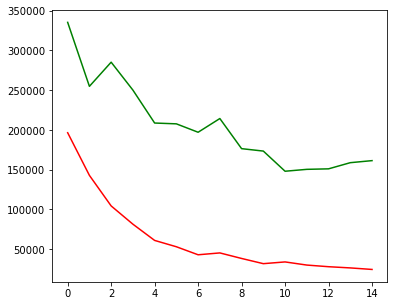

In [39]:
plt.figure(figsize=(6, 5))
plt.plot(history.history['loss'], color='r')
plt.plot(history.history['val_loss'], color='g')
plt.show()

In [40]:
Y_pred = np.round(model.predict(X_test))

38/38 [==============================] - 10s 244ms/step


In [41]:
# Calculate the mean squared error
mse = mean_squared_error(Y_test, Y_pred)

# Calculate the root mean squared error
rmse = np.sqrt(mse)

print("Root Mean Squared Error:", rmse)

r2 = r2_score(Y_test, Y_pred)
print("Test R^2 Score: {:.5f}".format(r2))

Root Mean Squared Error: 434.6618463271156
Test R^2 Score: 0.24056


In [42]:
image_sub = []

In [43]:
image_test = Path('C:/Users/vasan/OneDrive/EmissionsDatathon/Dataset/Data/Test')

In [44]:
testpaths = pd.Series(list(image_test.glob(r'**/*.png')), name='Testpath').astype(str)

In [45]:
df_testpaths = testpaths.to_frame()

In [46]:
res = os.listdir(image_test)
df_testpaths['Name'] = pd.DataFrame (res, columns = ['TestName'])

In [47]:
def image_processingsub(fil):
#Open image and import it as a numpy array
    
    
    im2 = imread(fil)
    im2 = cv2.resize(im2, (217, 217))
    im2_rgb = color.rgba2rgb(im2)
    im2_hsv = rgb2hsv(im2_rgb)
    
    mask = im2_hsv[:,:,1] > 0.4
    
    red = im2[:,:,0]*mask
    green = im2[:,:,1]*mask
    blue = im2[:,:,2]*mask
    mask2 = np.dstack((red,green,blue))
    
    feature_matrix = np.zeros((217,217))
    
    for i in range(0,mask2.shape[0]):
        for j in range(0,mask2.shape[1]):
            feature_matrix[i][j] = ((int(mask2[i,j,0]) + int(mask2[i,j,1]) + int(mask2[i,j,2]))/3)
        
    features = np.reshape(feature_matrix, (217*217))
    
    return features

In [48]:
for file in tqdm(df_testpaths['Testpath'].tolist()[:]):
    image_sub.append(image_processingsub(file))

100%|██████████| 20/20 [00:01<00:00, 17.28it/s]


In [49]:
X_sub = np.array(image_sub)

In [50]:
X_sub.shape

(20, 47089)

In [51]:
np.save('sub_image.npy',X_sub,allow_pickle=True)

In [52]:
X_sub = X_sub.reshape(X_sub.shape[0], img_rows, img_cols, 1)
X_sub = X_sub.reshape(X_sub.shape[0], img_rows, img_cols, 1)

In [53]:
Y_sub = np.round(model.predict(X_sub))

1/1 [==============================] - 0s 184ms/step


In [54]:
Y_sub

array([[237.],
       [527.],
       [270.],
       [177.],
       [181.],
       [428.],
       [566.],
       [293.],
       [408.],
       [332.],
       [259.],
       [311.],
       [256.],
       [164.],
       [360.],
       [ 79.],
       [405.],
       [271.],
       [305.],
       [155.]], dtype=float32)

In [55]:
np.savetxt('16b.csv', Y_sub, delimiter=',')